<a href="https://colab.research.google.com/github/FarisQanit/File_MachineLearning/blob/main/Copy_of_Aksara_Jawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 29 kB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# upload kaggle api from kaggle account
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vzrenggamani/hanacaraka
!mkdir dataset
!unzip hanacaraka.zip -d dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

image = []
label = []
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        if filename.endswith('.png'):
            image.append(os.path.join(dirname, filename).split('/')[-1])
            label.append(os.path.join(dirname, filename).split('/')[-2])

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
IMAGE_PATH = '/content/dataset/'

df_full = pd.DataFrame({'image_id':image, 'label':label})

#FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(IMAGE_PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))

    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,4694061835423836914_base64_5.png,ha
1,4693980454196420991_base64_5.png,ha
2,4693920961552490237_base64_5.png,ha
3,4693761962226194636_base64_5.png,ha
4,4694059174124519767_base64_5.png,ha


In [ ]:
# Define class
label = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na',
         'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']
ints = np.arange(0, len(label))
dicts = dict(zip(label, ints))

In [ ]:
class Aksara(Dataset):
    def __init__(self, x, y, path, maps_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.dicts = maps_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.y[idx]
        label = self.label_2_ints(label)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def label_2_ints(self, x):
        label_id = None
        for key, values in self.dicts.items():
            if x == key:
                label_id = values
        return label_id

    def __len__(self):
        return len(self.X)

In [ ]:
# split dataset train test 17:3
X_trainval, X_test, y_trainval, y_test = train_test_split(df['image_id'].values, df['label'].values,
                                                          test_size=0.15, stratify=df['label'].values,
                                                          random_state=8)

# split train dataset to train val 8:2
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  stratify=y_trainval, test_size=0.2,
                                                  random_state=8)
len(X_train), len(X_val), len(X_test)

(1061, 266, 235)

In [ ]:
# preprocess input
train_transform = T.Compose([T.Resize((128,128)),
                             T.RandomRotation((5, 30)),
                             T.RandomAffine((0,50)),
                             T.RandomCrop(size=(100,100)),
                             T.ToTensor()])

val_transform = T.Compose([T.Resize((128,128)),
                           T.ToTensor()])

train_set = Aksara(X_train, y_train, IMAGE_PATH, transform=train_transform)
val_set = Aksara(X_val, y_val, IMAGE_PATH, transform=val_transform)
test_set = Aksara(X_test, y_test, IMAGE_PATH, transform=val_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

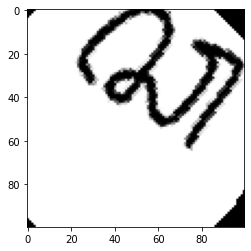

In [ ]:
# plot random image
img, label = train_set[random.randint(0, len(X_train))]

plt.imshow(img.permute(1,2,0))

In [ ]:
# define model + fc layer

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
#model.classifier[6] = nn.Linear(4096, 20)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# function to calculate acc
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
# define scheduler to adjust lr between iteration

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [ ]:
# train model

train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()

        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)

        train_loss += loss
        train_acc += accuracy(output, label)

        loss.backward()
        optimizer.step()


        scheduler.step()

    else:
        with torch.no_grad():
            model.eval()

            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss

    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 1/20.. train loss 3.132.. val loss 3.034.. train accuracy 0.070.. val accuracy 0.049.. time 106.554 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 2/20.. train loss 2.487.. val loss 2.128.. train accuracy 0.249.. val accuracy 0.325.. time 107.704 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 3/20.. train loss 1.634.. val loss 2.246.. train accuracy 0.472.. val accuracy 0.247.. time 107.101 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 4/20.. train loss 1.201.. val loss 4.399.. train accuracy 0.603.. val accuracy 0.231.. time 105.590 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 5/20.. train loss 1.053.. val loss 2.130.. train accuracy 0.656.. val accuracy 0.542.. time 103.483 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 6/20.. train loss 0.993.. val loss 1.921.. train accuracy 0.687.. val accuracy 0.538.. time 107.812 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 7/20.. train loss 0.820.. val loss 0.886.. train accuracy 0.748.. val accuracy 0.731.. time 104.637 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 8/20.. train loss 0.743.. val loss 0.652.. train accuracy 0.761.. val accuracy 0.788.. time 106.142 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 9/20.. train loss 0.738.. val loss 0.628.. train accuracy 0.752.. val accuracy 0.822.. time 105.278 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.630.. val loss 0.498.. train accuracy 0.807.. val accuracy 0.840.. time 104.891 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.562.. val loss 0.633.. train accuracy 0.831.. val accuracy 0.846.. time 106.636 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.475.. val loss 0.639.. train accuracy 0.859.. val accuracy 0.804.. time 107.544 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.314.. val loss 0.306.. train accuracy 0.899.. val accuracy 0.916.. time 106.948 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.371.. val loss 0.378.. train accuracy 0.875.. val accuracy 0.895.. time 104.546 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.334.. val loss 0.344.. train accuracy 0.897.. val accuracy 0.889.. time 106.703 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.270.. val loss 0.310.. train accuracy 0.917.. val accuracy 0.909.. time 105.417 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.272.. val loss 0.335.. train accuracy 0.916.. val accuracy 0.899.. time 105.474 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.246.. val loss 0.282.. train accuracy 0.921.. val accuracy 0.919.. time 104.879 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.220.. val loss 0.277.. train accuracy 0.927.. val accuracy 0.923.. time 101.037 s


  0%|          | 0/34 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.235.. val loss 0.283.. train accuracy 0.929.. val accuracy 0.923.. time 105.346 s


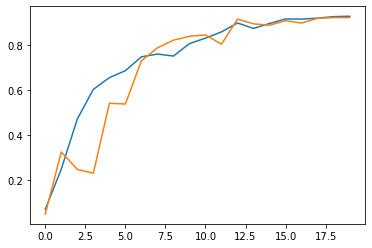

In [ ]:
# plot acc
plt.plot(train_accuracy)
plt.plot(val_acc)

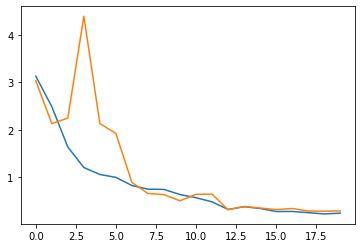

In [ ]:
# plot loss
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
# test function with softmax activation
def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

In [ ]:
# test dataset
test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

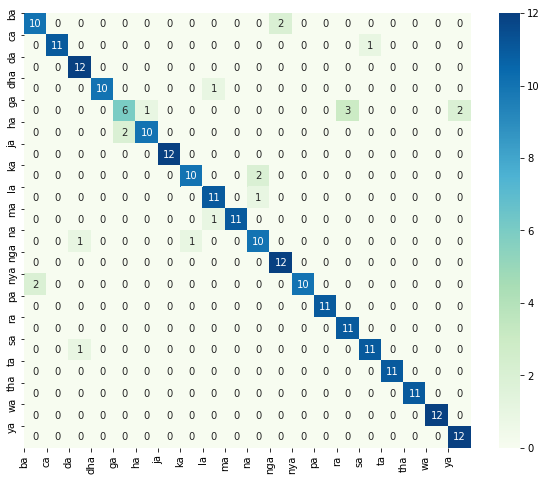

In [ ]:
# plot conf matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu')
plt.xticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0, len(list(dicts.keys()))), labels = list(dicts.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        12
           1       1.00      0.92      0.96        12
           2       0.86      1.00      0.92        12
           3       1.00      0.91      0.95        11
           4       0.75      0.50      0.60        12
           5       0.91      0.83      0.87        12
           6       1.00      1.00      1.00        12
           7       0.91      0.83      0.87        12
           8       0.85      0.92      0.88        12
           9       1.00      0.92      0.96        12
          10       0.77      0.83      0.80        12
          11       0.86      1.00      0.92        12
          12       1.00      0.83      0.91        12
          13       1.00      1.00      1.00        11
          14       0.79      1.00      0.88        11
          15       0.92      0.92      0.92        12
          16       1.00      1.00      1.00        11
          17       1.00    

In [ ]:
label = ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na',
         'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']
ints = np.arange(0, len(label))
dicts2 = dict(zip(ints, label))

def ints_2_label(x):
    label = None
    for key, values in dicts2.items():
        if x == key:
            label = values
    return label

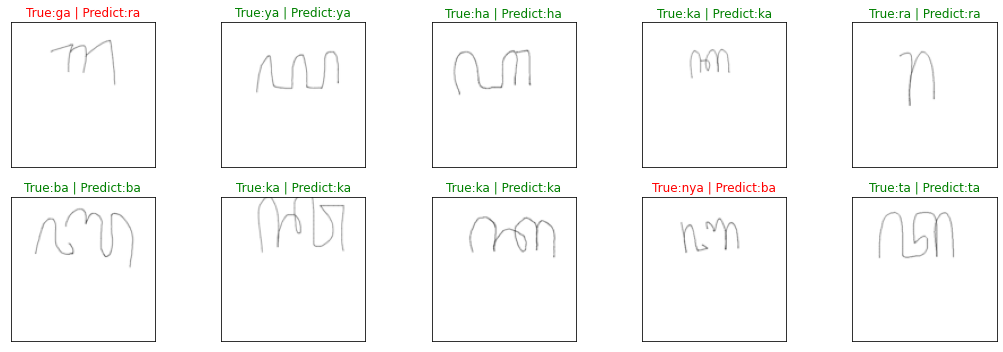

In [ ]:
# plot random test
random_selection = np.random.randint(0, len(test_predict), 10)

fig = plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title('True:{} | Predict:{}'.format(ints_2_label(label), ints_2_label(test_predict[idx])),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() #want faster comment or delete this
plt.show()